https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c

In [61]:
import numpy as np
import os
from PIL import Image
import torch
import torchvision
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
%matplotlib inline

In [2]:
np.random.seed(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
path = 'W:\\datasets\\asbestos\\line-segmentation\\'
os.listdir(path)

['aug_images_224',
 'aug_masks_224',
 'images',
 'images_encoder',
 'macro_fullsize.xml',
 'masks',
 'masks_encoder',
 'v1']

In [13]:
for folder in os.listdir(path):
    pathes = []
    for pth, dirs, files in os.walk(os.path.join(path, folder)):
        for file in files:
            pathes.append(os.path.join(pth, file))
    if folder == 'images_encoder':
        img_pathes = pathes
    elif folder == 'masks_encoder':
        lbl_pathes = pathes
        
img_pathes.sort()
lbl_pathes.sort()

In [14]:
img_pathes

['W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05086_5.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05090_1.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05090_13.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05090_18.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05091_1.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2638_2.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2644_17.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2645_14.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2645_6.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2647_12.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2648_11.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\IMG_2648_12.png',
 'W:\\datasets\\asbestos\\line-segmentation\\images_encod

In [15]:
import torch
from torch.utils import data

T = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

class Dataset(data.Dataset):
    def __init__(self, path, subset = 'train', transform = None):

        for folder in os.listdir(path):
            pathes = []
            for pth, dirs, files in os.walk(os.path.join(path, folder)):
                for file in files:
                    pathes.append(os.path.join(pth, file))
            if folder == 'images_encoder':
                img_pathes = pathes
            elif folder == 'masks_encoder':
                lbl_pathes = pathes
   
        img_pathes.sort()
        lbl_pathes.sort()
        
        items = list(zip(img_pathes, lbl_pathes))

        if subset == 'train':
            self.items = items[: int(0.95 * len(items))]
        elif subset == 'valid':
            self.items = items[int(0.95 * len(items)):]
            
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, index):
        img_name, msk_name = self.items[index]

        image = Image.open(img_name)
        mask = Image.open(msk_name).convert('L')

        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        
        return image, mask

In [16]:
train_data = Dataset(path, subset='train', transform=T)
valid_data = Dataset(path, subset='valid', transform=T)

In [17]:
train_data.__len__(), valid_data.__len__()

(19, 1)

In [18]:
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=16, 
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, 
                                           batch_size=16, 
                                           shuffle=False)

In [85]:
from torchvision.models import resnet34
class Net(nn.Module): #Multi-task learning
    def __init__(self, net='resnet18', pretrained=True):
        super(Net, self).__init__()
        self.net = net
         
        if self.net == 'resnet18':
            self.model = models.resnet34(pretrained)
            self.model.asbestos_cls = nn.Linear(1000, 2)
        
    def forward(self, x):
        if (self.net == 'resnet18'):
            x = self.model.conv1(x)
            x = self.model.bn1(x)
            x = self.model.relu(x)
            x = self.model.maxpool(x)
            x = self.model.layer1(x)
            x = self.model.layer2(x)
            x = self.model.layer3(x)
            x = self.model.layer4(x)
            x = self.model.avgpool(x) # without last fully connected(2048, 1000) layer
            x = x.view(x.size(0), -1)
            x = self.model.fc(x)
            x = self.model.asbestos_cls(x)

        return x


In [86]:
model = Net(net='resnet18', pretrained=True).to(device)
model

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [87]:
layer = model._modules.get('avgpool')

In [88]:
from torchsummary import summary

model = Net(net='resnet18', pretrained=True)
summary(model.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

          Linear-125                    [-1, 2]           2,002
Total params: 21,799,674
Trainable params: 21,799,674
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 96.29
Params size (MB): 83.16
Estimated Total Size (MB): 180.02
----------------------------------------------------------------


In [89]:
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [90]:
def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    plt.imshow(img)
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    print(t_img)
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(512)
    print(my_embedding)
    
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    print(h)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

In [91]:
model.eval()

Net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

tensor([[[[ 0.1939,  0.2111,  0.3481,  ..., -0.3369, -0.9877, -1.0048],
          [ 0.3994,  0.4679,  0.4851,  ..., -0.7137, -0.4054,  0.1939],
          [ 0.9474, -0.1999,  0.8618,  ...,  0.2967, -0.3541, -0.0287],
          ...,
          [-0.1314, -0.3541, -0.1828,  ..., -0.0801, -0.8678, -0.8849],
          [-1.0562, -0.8507, -0.1657,  ...,  0.2111, -0.9192, -0.9534],
          [-0.9705, -0.4226, -0.0287,  ..., -1.0219, -0.7650, -1.0219]],

         [[ 0.5378,  0.5553,  0.6429,  ..., -0.2325, -0.8978, -0.9153],
          [ 0.6254,  0.7829,  0.7829,  ..., -0.6001, -0.2675,  0.3452],
          [ 1.1681,  0.0476,  1.1681,  ...,  0.4328, -0.2325,  0.1176],
          ...,
          [ 0.1527, -0.0749,  0.0826,  ...,  0.1527, -0.6702, -0.7402],
          [-0.9853, -0.6527,  0.1176,  ...,  0.4328, -0.7927, -0.8452],
          [-0.9153, -0.2500,  0.2752,  ..., -0.8978, -0.6702, -0.9678]],

         [[ 1.0017,  1.0191,  1.1237,  ...,  0.0953, -0.5670, -0.5844],
          [ 0.9494,  1.2108,  

AttributeError: 'NoneType' object has no attribute 'register_forward_hook'

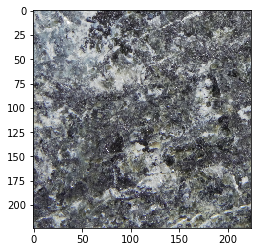

In [92]:
pic_one_vector = get_vector(img_pathes[0])
pic_two_vector = get_vector(img_pathes[1])

In [72]:
img_pathes[0]

'W:\\datasets\\asbestos\\line-segmentation\\images_encoder\\DSC05086_5.png'

In [53]:
criterion = criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum = 0.9)

In [54]:
epochs = 10
x = list(range(1, epochs + 1))
loss_list = []
val_loss_list = []
accuracy_list = []
v_accuracy_list = []

In [55]:
%%time
from IPython.display import clear_output
print("epoch|loss |val_loss|acc  /v_acc|")
for epoch in range(epochs):  # loop over the dataset multiple times

    for phase in ['train', 'valid']:
        
        if phase == 'train':
            
            model.train(True)
            
            running_loss = 0.0
            correct = 0
            total = 0

            for i, data in enumerate(train_loader):
                # get the inputs; data is a list of [inputs, labels]
                inputs, asbestos = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                out_asbestos = model(inputs)

                loss = criterion(out_asbestos, asbestos)

                loss.backward()
                
                optimizer.step()

                # print statistics
                running_loss += loss.item()

                _, asbestos_pred = torch.max(out_asbestos.data, 1)
                
                total += asbestos.size(0)
                
                asbestos_correct += (asbestos_pred == asbestos).sum().item()
            
            
        elif phase == 'valid':
            
            model.train(False)
            
            validation_loss = 0.
            v_correct = 0
            v_total = 0
            
            for i, v_data in enumerate(valid_loader):
                v_loss = 0
               
                
                v_inputs, v_asbestos = v_data[0].to(device), v_data[1].to(device)

                v_out_asbestos = model(v_inputs)


                v_loss += criterion(v_out_asbestos, v_asbestos)
                

                validation_loss += v_loss.item() 
                _, v_asbestos_pred = torch.max(v_out_asbestos.data, 1)
                

                v_total += v_asbestos.size(0)
                
                v_correct += (v_asbestos_pred == v_asbestos).sum().item()
                
    #print("epoch|loss |val_loss|age(acc/v_acc)|gender(acc/v_acc)|race(acc/v_acc)|")
    print('%5d|%.3f| %.3f  | %.3f / %.3f |  %.3f / %.3f  | %.3f / %.3f |' %
          (epoch + 1, running_loss / len(train_loader), validation_loss / len(valid_loader), 
           correct / total, v_correct / v_total))           
    
    loss_list.append(running_loss / len(train_loader))
    val_loss_list.append(validation_loss / len(valid_loader))
    
    accuracy_list.append(correct / total)
    v_accuracy_list.append(v_correct / v_total)
    
print('Finished Training')

epoch|loss |val_loss|acc  /v_acc|


RuntimeError: Expected object of scalar type Long but got scalar type Float for argument #2 'target'

In [ ]:
plt.figure(figsize=(16,8))
plt.title("learning curve")
plt.plot(x, loss_list, label= 'training')
plt.plot(x, val_loss_list, label= 'validation')
plt.xlabel("Time (epochs)")
plt.ylabel("Cost")
plt.legend();